In [1]:
# dependencies for notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import signal
import localreg

In [2]:
#pip install localreg


https://pypi.org/project/localreg/#description

# Introduction

This notebook develops a rigorous methodology for testing and evaluating smoothing methods for hydrological data collected via laboratory methods. These data were taken to experimentally validate a newly developed analytical model for overland flow on hillslopes of different geometry (Lapides et al. 2020). The model collapses the geometry of different hillslopes into a parameter ($a$) describing the degree of convergence of the slope's drainage divides (Lapides et al. 2020). The raw data are cumulative runoff mass time series from multiple experimental runs of each hillslope. The hydrographs (discharge vs. time plots) produced from the measurements can be useful for comparison to analytical results. However, instrumental precision and imperfections in the experimental set-up produce a large amount of noise that hinders analysis.

The ultimate aim is to determine whether enough noise can be removed from the data through smoothing in order to detect qualitative differences between different hillslope shapes. The smoothing methods used in this notebook are listed in the table below and are distinguished by three smoothing parameters: the fraction of nearest neighbors included in the kernel, $f$; the degree of local polynomial regression, $d$; and the number of iterative residual-based reweightings, $t$ (Cleveland, 1979).

|      | Name|$f$|$d$|$t$|
|-|-|-|-|-|
|1|moving average without reweightings|0.05|0|0|
|2|linear locally-weighted regression<br>without reweightings|0.04|1|0|
|3|linear locally-weighted regression<br>with three residual-based reweightings<br>(robust locally-weighted regression)|0.03|1|3|
|4|quadratic locally-weighted regression<br>without reweightings|0.08|2|0|

We compare the results of these methods using the **root mean squared error** (RMSE) of the smoothed data and a **Roughness Index**, which we shall define later.

# Execution:

## Preprocessing

### Import the data.

Read full data into a multi-indexed Pandas DataFrame.

In [3]:
full_data = pd.read_excel('Hillslope_data.xlsx',header=[4,5,6])
pd.set_option('display.max_columns', 999)
full_data.head(5)

a=0.05                                                                \
     RUN 1                                  RUN 2                          
  time (s) mass (g)   notes start   stop time (s) mass (g)   notes start   
0      0.0      0.8     NaN  16.0  334.0      0.0      0.0     NaN  14.0   
1      1.0      0.8     NaN   NaN    NaN      1.0      0.0     NaN   NaN   
2      2.0      0.0     NaN   NaN    NaN      2.0      0.0     NaN   NaN   
3      3.0      0.0  <-tare   NaN    NaN      3.0      0.0  <-tare   NaN   
4      4.0      0.1     NaN   NaN    NaN      4.0      0.0     NaN   NaN   

                                                                             \
            RUN 3                                RUN 4                        
    stop time (s) mass (g) notes start   stop time (s) mass (g) notes start   
0  318.0      0.0     0.00   NaN  53.0  360.0      0.0      0.0   NaN  90.0   
1    NaN      1.0     0.00   NaN   NaN    NaN      1.0      0.0   NaN   NaN   
2    NaN      2.0     0.00   NaN   NaN    NaN      2.0      0.0   NaN   NaN   
3    NaN      3.0     0.00   NaN   NaN    NaN      3.0      0.0   NaN   NaN   
4    NaN      4.0     0.05   NaN   NaN    NaN      4.0      0.0   NaN   NaN   

                                               a=-0.05                         \
            RUN 5                                RUN 1                          
    stop time (s) mass (g) notes start   stop time (s) mass (g)   notes start   
0  389.0      0.0      0.0   NaN  77.0  378.0      0.0      0.4     NaN  15.0   
1    NaN      1.0      0.0   NaN   NaN    NaN      1.0      0.4     NaN   NaN   
2    NaN      2.0      0.0   NaN   NaN    NaN      2.0      0.4     NaN   NaN   
3    NaN      3.0      0.0   NaN   NaN    NaN      3.0      0.0  <-tare   NaN   
4    NaN      4.0      0.0   NaN   NaN    NaN      4.0      0.0     NaN   NaN   

                                                                           \
            RUN 2                                  RUN 3                    
    stop time (s) mass (g)   notes start   stop time (s) mass (g)   notes   
0  318.0        0      0.4     NaN  12.0  314.0      0.0     0.65     NaN   
1    NaN        1      0.4     NaN   NaN    NaN      1.0     0.65     NaN   
2    NaN        2      0.4     NaN   NaN    NaN      2.0     0.65     NaN   
3    NaN        3      0.4     NaN   NaN    NaN      3.0     0.65     NaN   
4    NaN        4      0.0  <-tare   NaN    NaN      4.0     0.00  <-tare   

                    a=0                                                  \
                  RUN 1                                  RUN 2            
  start   stop time (s) mass (g)   notes start   stop time (s) mass (g)   
0   9.0  313.0      0.0     6.35     NaN  18.0  323.0      0.0     0.05   
1   NaN    NaN      1.0     6.35     NaN   NaN    NaN      1.0     0.05   
2   NaN    NaN      2.0     6.35     NaN   NaN    NaN      2.0     0.05   
3   NaN    NaN      3.0     6.35     NaN   NaN    NaN      3.0     0.05   
4   NaN    NaN      4.0     0.00  <-tare   NaN    NaN      4.0     0.05   

                                                                       \
                           RUN 3                                RUN 4   
     notes start   stop time (s) mass (g) notes start   stop time (s)   
0  <-START   0.0  306.0      0.0     4.15   NaN  11.0  311.0      0.0   
1      NaN   NaN    NaN      1.0     4.15   NaN   NaN    NaN      1.0   
2      NaN   NaN    NaN      2.0     4.15   NaN   NaN    NaN      2.0   
3      NaN   NaN    NaN      3.0     4.15   NaN   NaN    NaN      3.0   
4      NaN   NaN    NaN      4.0     4.15   NaN   NaN    NaN      4.0   

                                 
                                 
  mass (g)   notes start   stop  
0     0.15     NaN  10.0  310.0  
1     0.10     NaN   NaN    NaN  
2     0.10     NaN   NaN    NaN  
3     0.00  <-tare   NaN    NaN  
4     0.00     NaN   NaN    NaN

### Trim data and convert units.

Get the names of the slopes (the slope shapes).

In [4]:
slopes = full_data.columns.levels[0].values
slopes

array(['a=-0.05', 'a=0', 'a=0.05'], dtype=object)

Take one run from the full data. First let's look at **RUN 2** of the **a=-0.05** slope.

In [5]:
slope = 'a=-0.05'
run = 'RUN 2'
untrimmed_data = full_data[slope][run]

Drop the data before the scale is tared, and after the last mass reading. Find the time of ponding (the start time), $t_p$, and subtract it from the time values. Also, find the time when rainfall stops, $t_r$.

In [6]:
t_p = untrimmed_data['start'].values[0]
t_r = untrimmed_data['stop'].values[0]

In [7]:
if np.sum(np.isnan(untrimmed_data['mass (g)'])==True) != 0:
    last_index = -1 + np.where(np.isnan(untrimmed_data['mass (g)'])==True)[0][0]
    if np.sum(untrimmed_data['notes']=='<-tare') == 1:
        tare_index = np.where(untrimmed_data['notes']=='<-tare')[0][0]
        data = untrimmed_data.loc[tare_index:last_index]
    else:
        tare_index = 0
        data = untrimmed_data.loc[tare_index:last_index]

else:
    if np.sum(untrimmed_data['notes']=='<-tare') == 1:
        tare_index = np.where(untrimmed_data['notes']=='<-tare')[0][0]
        data = untrimmed_data.loc[tare_index:]
    else:
        tare_index = 0
        data = untrimmed_data.loc[tare_index:]

Process raw mass data into volume data and into volume change per time (difference quotient of volume with respect to time)

In [8]:
density = 1 #g/cm^3
time = data['time (s)'].values
t_tp = time - t_p
tr_tp = t_r - t_p
mass = data['mass (g)'].values
volume_cm3 = mass/density
volume_diff = np.gradient(volume_cm3,t_tp)

## Smoothing

### Local Polynomial Regression

Perform local polynomial regression on the volume time series, using the 4 methods tabulated in the introduction.  

For **Methods** **1**, **2**, and **4** use`localreg`: https://pypi.org/project/localreg/#description

For **Method 3** use `statsmodels.nonparametric.lowess` with the default number of residual-based reweightings (3): https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [9]:
import localreg

frac_lr_0 = 0.05
frac_lr_1 = 0.04
frac_lowess = 0.03
frac_lr_2 = 0.08

lowess_volume_and_time = sm.nonparametric.lowess(volume_cm3,t_tp,frac=frac_lowess)
lowess_volume_cm3 = lowess_volume_and_time[:,1]

locreg_deg_0_volume_cm3= localreg.localreg(t_tp, volume_cm3, degree=0, kernel=localreg.tricube, frac=frac_lr_0)
locreg_deg_1_volume_cm3= localreg.localreg(t_tp, volume_cm3, degree=1, kernel=localreg.tricube, frac=frac_lr_1)
locreg_deg_2_volume_cm3= localreg.localreg(t_tp, volume_cm3, degree=2, kernel=localreg.tricube, frac=frac_lr_2)

Plot the smoothed volume curve

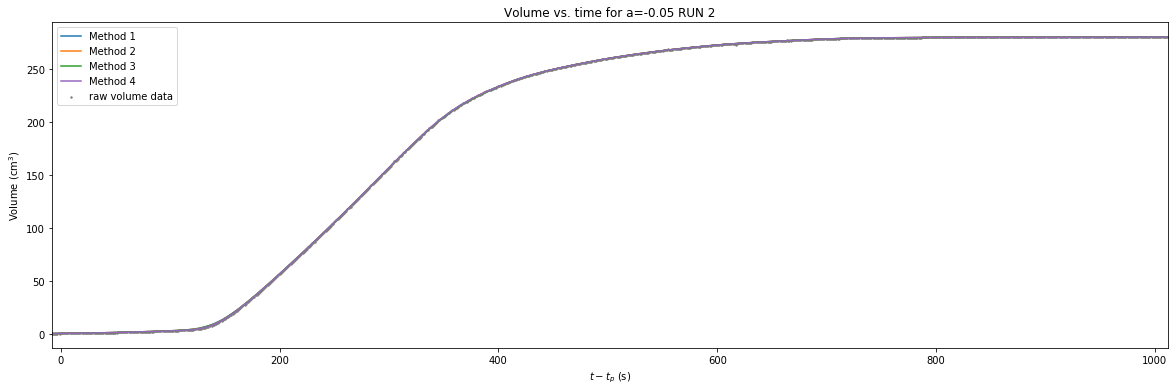

In [10]:
fig1 = plt.figure(1,(20,6))

ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(t_tp,volume_cm3,s=2,color='gray',label='raw volume data')
ax1.plot(t_tp,locreg_deg_0_volume_cm3,color='C0',label='Method 1')
ax1.plot(t_tp,locreg_deg_1_volume_cm3,color='C1',label='Method 2')
ax1.plot(t_tp,lowess_volume_cm3,color='C2',label='Method 3')
ax1.plot(t_tp,locreg_deg_2_volume_cm3,color='C4',label='Method 4')
ax1.set_xlim(t_tp[0],t_tp[-1])
ax1.legend()
ax1.set_xlabel('$t - t_p$ (s)')
ax1.set_ylabel('Volume (cm$^3$)')
ax1.set_title('Volume vs. time for '+slope+' '+run)

plt.show()

All 4 smoothing methods seem to fit the volume curve pretty well, but we'll see greater differences once we produce hydrographs (by approximating the derivative of the volume curve).

### Obtaining hydrographs

Use `np.gradient` to approximate the discharge ($Q = \frac{dV}{dt}$) as difference quotients of smoothed volume data with respect to time, taking central differences in the interior and one-sided differences at the boundaries.

In [11]:
diff_lowess_volume_cm3 = np.gradient(lowess_volume_cm3,t_tp)
diff_locreg_deg_0_volume_cm3 = np.gradient(locreg_deg_0_volume_cm3,t_tp)
diff_locreg_deg_1_volume_cm3 = np.gradient(locreg_deg_1_volume_cm3,t_tp)
diff_locreg_deg_2_volume_cm3 = np.gradient(locreg_deg_2_volume_cm3,t_tp)

Plot the hydrographs ($Q$ vs. time)

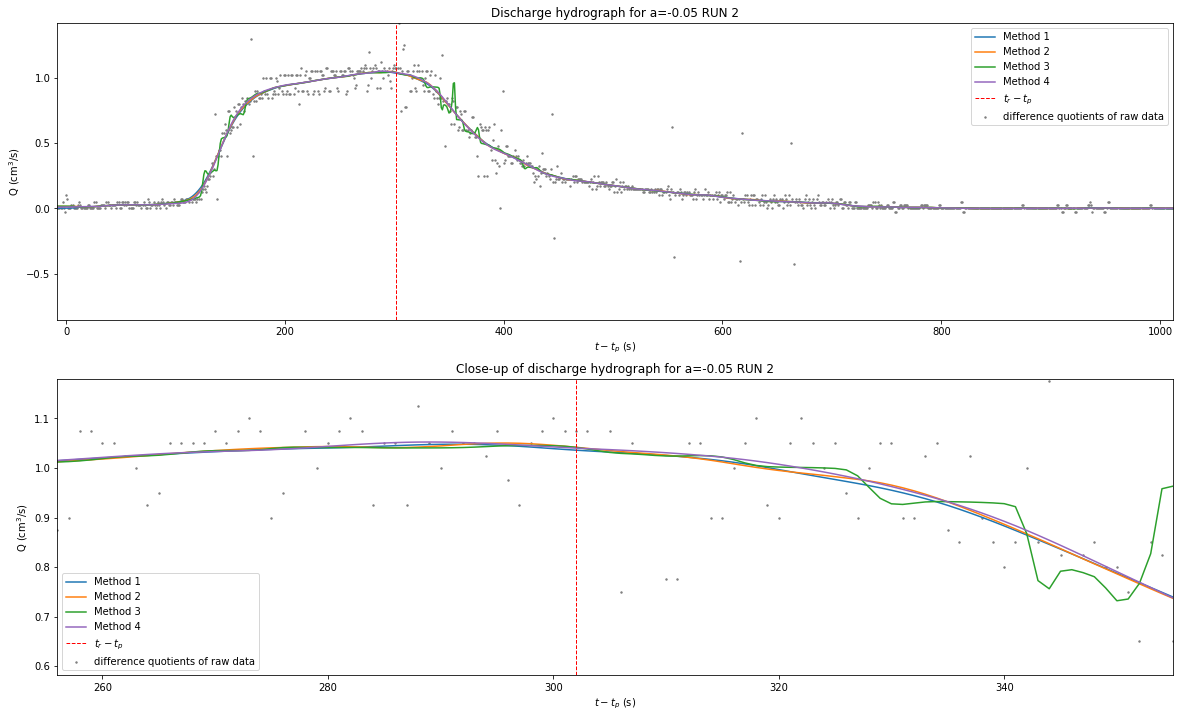

In [12]:
fig2 = plt.figure(1,(20,12))

ax2 = fig2.add_subplot(2,1,1)
ax2.scatter(t_tp,volume_diff,s=2,color='gray',label='difference quotients of raw data') 
ax2.plot(t_tp,diff_locreg_deg_0_volume_cm3,color='C0',label='Method 1')
ax2.plot(t_tp,diff_locreg_deg_1_volume_cm3,color='C1',label='Method 2')
ax2.plot(t_tp,diff_lowess_volume_cm3,color='C2',label='Method 3')
ax2.plot(t_tp,diff_locreg_deg_2_volume_cm3,color='C4',label='Method 4')
ax2.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax2.legend()
ax2.set_xlabel('$t - t_p$ (s)')
ax2.set_ylabel('Q (cm$^3$/s)')
ax2.set_ylim(-3*np.std(volume_diff)+np.mean(volume_diff),np.max(diff_lowess_volume_cm3)+np.std(volume_diff))#3*np.std(volume_diff)+np.mean(volume_diff))
ax2.set_xlim(t_tp[0],t_tp[-1])
ax2.set_title('Discharge hydrograph for '+slope+' '+run)

ax3 = fig2.add_subplot(2,1,2)
ax3.scatter(time[int(t_r)-50:int(t_r)+50] - t_p,volume_diff[int(t_r)-50:int(t_r)+50],s=2,color='gray',label='difference quotients of raw data')
ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_locreg_deg_0_volume_cm3[int(t_r)-50:int(t_r)+50],color='C0',label='Method 1')
ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_locreg_deg_1_volume_cm3[int(t_r)-50:int(t_r)+50],color='C1',label='Method 2')
ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_lowess_volume_cm3[int(t_r)-50:int(t_r)+50],color='C2',label='Method 3')
ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_locreg_deg_2_volume_cm3[int(t_r)-50:int(t_r)+50],color='C4',label='Method 4')
ax3.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax3.legend()
ax3.set_xlabel('$t - t_p$ (s)')
ax3.set_ylabel('Q (cm$^3$/s)')
ax3.set_ylim(-3*np.std(volume_diff[int(t_r)-50:int(t_r)+50])+np.mean(volume_diff[int(t_r)-50:int(t_r)+50]),np.max(diff_lowess_volume_cm3[int(t_r)-50:int(t_r)+50])+np.std(volume_diff[int(t_r)-50:int(t_r)+50]))
ax3.set_xlim(time[int(t_r)-50]-t_p,time[int(t_r)+49]-t_p)
ax3.set_title('Close-up of discharge hydrograph for '+slope+' '+run)

plt.show()

Using these smooth hydrographs, we can go back and tune the $f$ values by eye until we get a smooth curve that doesn't overfit the data for each smoothing method. Then we can compare *between* different smoothing methods. We can see immediately here that the curve produced by Method 3 is by far the worst because it adds in spikes and wiggles (even for its best $f$ value). It's more difficult to judge between the remaining 3 smoothing methods, so we'll need to look closer.

### Evaluating smoothing methods

**1. Measure of Fit**

First, we can look at the residuals of the local regression to see how fitted the smooth curves are to the raw data and determine if there are trends.  

Calculate the volume residuals and the root mean squared error (RMSE). The RMSE of each smoothing method should give us an idea of how fitted the smoothed volume curves are to the raw data for each smoothing method.

In [13]:
residuals_lowess_vol = volume_cm3 - lowess_volume_cm3
residuals_locreg_0_vol = volume_cm3 - locreg_deg_0_volume_cm3
residuals_locreg_1_vol = volume_cm3 - locreg_deg_1_volume_cm3
residuals_locreg_2_vol = volume_cm3 - locreg_deg_2_volume_cm3

RMSE_lowess = np.sqrt(np.mean(residuals_lowess_vol**2))
RMSE_locreg_0 = np.sqrt(np.mean(residuals_locreg_0_vol**2))
RMSE_locreg_1 = np.sqrt(np.mean(residuals_locreg_1_vol**2))
RMSE_locreg_2 = np.sqrt(np.mean(residuals_locreg_2_vol**2))

Plot the residuals.

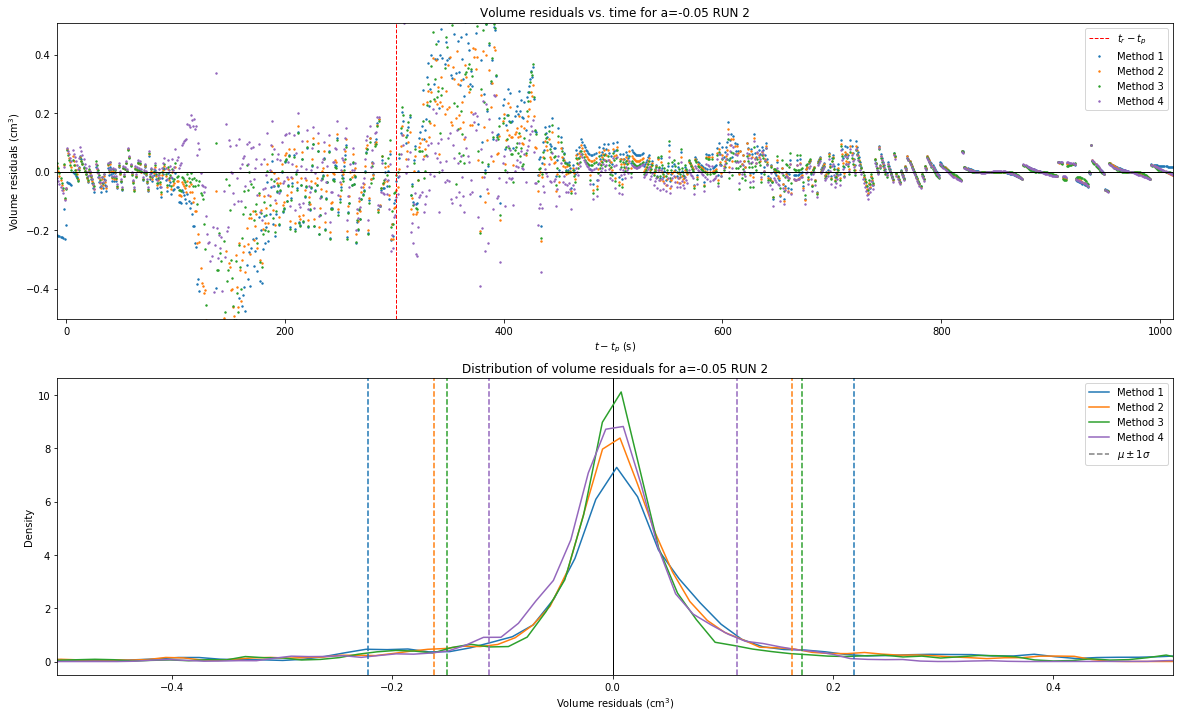

In [14]:
fig3 = plt.figure(1,(20,12))

ax4 = fig3.add_subplot(2,1,1)
ax4.scatter(t_tp,residuals_locreg_0_vol,s=2,color='C0',label='Method 1')
ax4.scatter(t_tp,residuals_locreg_1_vol,s=2,color='C1',label='Method 2')
ax4.scatter(t_tp,residuals_lowess_vol,s=2,color='C2',label='Method 3')
ax4.scatter(t_tp,residuals_locreg_2_vol,s=2,color='C4',label='Method 4')
ax4.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax4.axhline(0,lw=1,color='k')
ax4.legend()
ax4.set_xlabel('$t - t_p$ (s)')
ax4.set_ylabel('Volume residuals (cm$^3$)')
ax4.set_xlim(t_tp[0],t_tp[-1])
ax4.set_ylim(np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) - 
        3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])),
        np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 
        3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])))
ax4.set_title('Volume residuals vs. time for '+slope+' '+run)

ax5 = fig3.add_subplot(2,1,2)
ax5.axvline(0,lw=1,color='k')
sns.distplot(residuals_locreg_0_vol,color='C0',hist=False,norm_hist=True,ax=ax5,label='Method 1')
sns.distplot(residuals_locreg_1_vol,color='C1',hist=False,norm_hist=True,ax=ax5,label='Method 2')
sns.distplot(residuals_lowess_vol,color='C2',hist=False,norm_hist=True,ax=ax5,label='Method 3')
sns.distplot(residuals_locreg_2_vol,color='C4',hist=False,norm_hist=True,ax=ax5,label='Method 4')
ax5.axvline(np.mean(residuals_locreg_0_vol)-np.std(residuals_locreg_0_vol),linestyle='--',color='C0')
ax5.axvline(np.mean(residuals_locreg_1_vol)-np.std(residuals_locreg_1_vol),linestyle='--',color='C1')
ax5.axvline(np.mean(residuals_lowess_vol)-np.std(residuals_lowess_vol),linestyle='--',color='C2')
ax5.axvline(np.mean(residuals_locreg_2_vol)-np.std(residuals_locreg_2_vol),linestyle='--',color='C4')
ax5.axvline(np.mean(residuals_locreg_0_vol)+np.std(residuals_locreg_0_vol),linestyle='--',color='C0')
ax5.axvline(np.mean(residuals_locreg_1_vol)+np.std(residuals_locreg_1_vol),linestyle='--',color='C1')
ax5.axvline(np.mean(residuals_lowess_vol)+np.std(residuals_lowess_vol),linestyle='--',color='C2')
ax5.axvline(np.mean(residuals_locreg_2_vol)+np.std(residuals_locreg_2_vol),linestyle='--',color='C4')
ax5.plot(np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 
        3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 1,0,
         linestyle='--',color='gray',label='$\\mu \\pm 1\\sigma$')
ax5.legend()
ax5.set_xlabel('Volume residuals (cm$^3$)')
ax5.set_ylabel('Density')
ax5.set_xlim(np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) - 
        3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])),
        np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 
        3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])))
ax5.set_title('Distribution of volume residuals for '+slope+' '+run)

plt.show()

From the residual plot, we can see how fitted the smooth curves are at different sections. What's notable here is that Method 4 (purple) is much more fitted to the data than Method 1 (blue) along the rising limb (from around 100 to 200 seconds) and the falling limb (around 300 to 400 seconds). Accuracy in the rising and falling limb is important for later analysis (e.g. fitting the curve produced by the analytical solution), so it's important to take this into account.

From the density plot, we see how fitted the smooth curves are to the raw volume data. Each pair of dotted lines represents the $\pm$ 1 standard deviation interval about the mean of the residuals. Since the mean is nearly zero (the peaks are all close to zero), the RMSE is close to the standard deviation of the residuals. By the size of the standard deviations, we can quickly observe that Method 4 is most fitted, followed by Method 3, Method 2, and finally Method 1. The actual RMSE values give the same order.

In [15]:
print('Method 4: ',RMSE_locreg_2,)
print('Method 3: ',RMSE_lowess)
print('Method 2: ',RMSE_locreg_1)
print('Method 1: ',RMSE_locreg_0)

Method 4:  0.11251831786979477
Method 3:  0.16152058327852972
Method 2:  0.16277448566848796
Method 1:  0.22096062923391585


**2. Smoothness**

However, we cannot simply take the smoothing method with the lowest RMSE, since this method may *overfit* the data and produce a rougher, more "wiggly" curve. We need to choose the smoothing method that strikes a balance between its faithfulness to the data (measured by RMSE) and it smoothness.

The "roughness" of the plot should increase with the frequency of concavity changes and the amount of curvature of the plot (since very "wiggly" plots have more sections of high curvature).

Changes in concavity are marked by the change in the sign of the second derivative $\frac{d^2Q}{dt^2}$. Curvature is defined as $\kappa = \frac{|f"(x)|}{(1 + f'(x)^2)^\frac{3}{2}}$.

First let's look at the frequency of concavity reversals. Calculate $\frac{d^2Q}{dt^2}$.

In [16]:
dQdt_lowess = np.gradient(diff_lowess_volume_cm3,t_tp)
dQdt_locreg_0 = np.gradient(diff_locreg_deg_0_volume_cm3,t_tp)
dQdt_locreg_1 = np.gradient(diff_locreg_deg_1_volume_cm3,t_tp)
dQdt_locreg_2 = np.gradient(diff_locreg_deg_2_volume_cm3,t_tp)

dQ2dt2_lowess = np.gradient(dQdt_lowess,t_tp)
dQ2dt2_locreg_0 = np.gradient(dQdt_locreg_0,t_tp)
dQ2dt2_locreg_1 = np.gradient(dQdt_locreg_1,t_tp)
dQ2dt2_locreg_2 = np.gradient(dQdt_locreg_2,t_tp)

Perform a Fourier analysis to calculate the power spectral density for the second derivative curves. Every "cycle" in the second derivative curve marks a reversal of concavity and a subsequent reversal back, so the mean frequency in the second derivative curve should be equal to half of the mean frequency of concavity reversal.

In [17]:
dQ2dt2_freqs_lowess,dQ2dt2_power_lowess = signal.periodogram(dQ2dt2_lowess,window='hanning')
dQ2dt2_freqs_locreg_0,dQ2dt2_power_locreg_0 = signal.periodogram(dQ2dt2_locreg_0,window='hanning')
dQ2dt2_freqs_locreg_1,dQ2dt2_power_locreg_1 = signal.periodogram(dQ2dt2_locreg_1,window='hanning')
dQ2dt2_freqs_locreg_2,dQ2dt2_power_locreg_2 = signal.periodogram(dQ2dt2_locreg_2,window='hanning')

mean_dQ2dt2_freqs_lowess = np.sum(dQ2dt2_freqs_lowess*dQ2dt2_power_lowess)/np.sum(dQ2dt2_power_lowess)
mean_dQ2dt2_freqs_locreg_0 = np.sum(dQ2dt2_freqs_locreg_0*dQ2dt2_power_locreg_0)/np.sum(dQ2dt2_power_locreg_0)
mean_dQ2dt2_freqs_locreg_1 = np.sum(dQ2dt2_freqs_locreg_1*dQ2dt2_power_locreg_1)/np.sum(dQ2dt2_power_locreg_1)
mean_dQ2dt2_freqs_locreg_2 = np.sum(dQ2dt2_freqs_locreg_2*dQ2dt2_power_locreg_2)/np.sum(dQ2dt2_power_locreg_2)

Plot the second derivative curves and their power spectra.

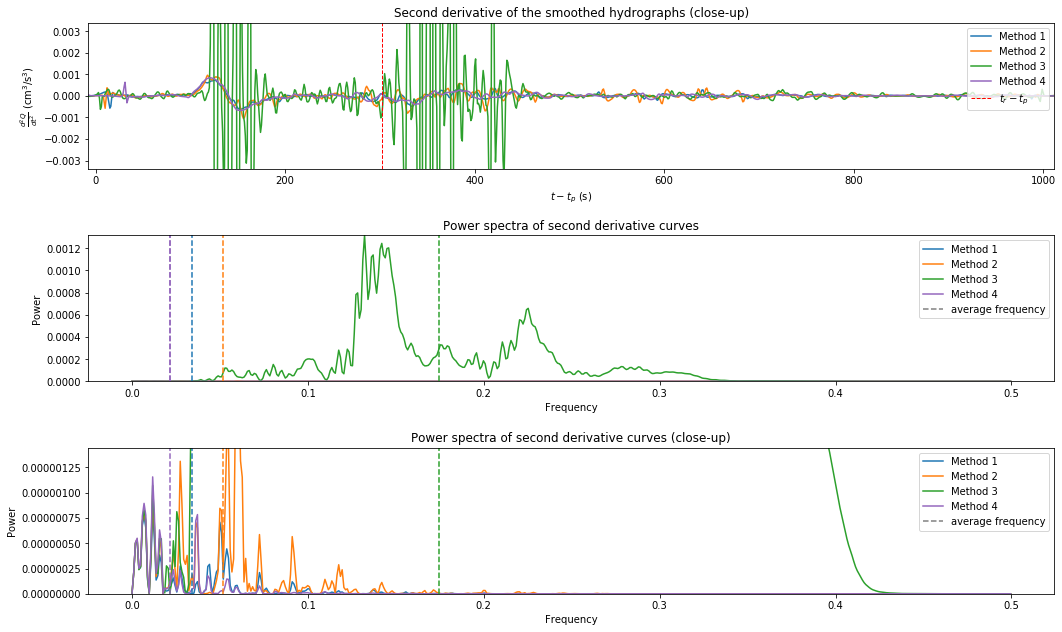

In [18]:
fig9 = plt.figure(1,(15,9))

ax15 = fig9.add_subplot(3,1,1)
ax15.plot(t_tp,dQ2dt2_locreg_0,color='C0',label='Method 1')
ax15.plot(t_tp,dQ2dt2_locreg_1,color='C1',label='Method 2')
ax15.plot(t_tp,dQ2dt2_lowess,color='C2',label='Method 3')
ax15.plot(t_tp,dQ2dt2_locreg_2,color='C4',label='Method 4')
ax15.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax15.set_ylim(-np.std(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2)))
                      +np.mean(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2))),
              np.std(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2)))
                      +np.mean(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2))))
ax15.set_xlim(t_tp[0],t_tp[-1])
ax15.legend()
ax15.set_xlabel('$t - t_p$ (s)')
ax15.set_ylabel('$\\frac{d^2Q}{dt^2}$ (cm$^3$/s$^3$)')
ax15.set_title('Second derivative of the smoothed hydrographs (close-up)')

ax16 = fig9.add_subplot(3,1,2)
ax16.plot(dQ2dt2_freqs_locreg_0,dQ2dt2_power_locreg_0,color='C0',label='Method 1')
ax16.plot(dQ2dt2_freqs_locreg_1,dQ2dt2_power_locreg_1,color='C1',label='Method 2')
ax16.plot(dQ2dt2_freqs_lowess,dQ2dt2_power_lowess,color='C2',label='Method 3')
ax16.plot(dQ2dt2_freqs_locreg_2,dQ2dt2_power_locreg_2,color='C4',label='Method 4')
ax16.axvline(mean_dQ2dt2_freqs_locreg_0,linestyle='--',color='C0')
ax16.axvline(mean_dQ2dt2_freqs_locreg_1,linestyle='--',color='C1')
ax16.axvline(mean_dQ2dt2_freqs_lowess,linestyle='--',color='C2')
ax16.axvline(mean_dQ2dt2_freqs_locreg_2,linestyle='--',color='C4')
ax16.axvline(mean_dQ2dt2_freqs_locreg_2,linestyle='--',color='C4')
ax16.plot(0,-1,linestyle='--',color='gray',label='average frequency')
ax16.set_ylim(0,np.max(np.concatenate((dQ2dt2_power_locreg_0,dQ2dt2_power_locreg_1,dQ2dt2_power_lowess,dQ2dt2_power_locreg_2))))
ax16.legend()
ax16.set_xlabel('Frequency')
ax16.set_ylabel('Power') 
ax16.set_title('Power spectra of second derivative curves')

ax17 = fig9.add_subplot(3,1,3)
ax17.plot(dQ2dt2_freqs_locreg_0,dQ2dt2_power_locreg_0,color='C0',label='Method 1')
ax17.plot(dQ2dt2_freqs_locreg_1,dQ2dt2_power_locreg_1,color='C1',label='Method 2')
ax17.plot(dQ2dt2_freqs_lowess,dQ2dt2_power_lowess,color='C2',label='Method 3')
ax17.plot(dQ2dt2_freqs_locreg_2,dQ2dt2_power_locreg_2,color='C4',label='Method 4')
ax17.axvline(mean_dQ2dt2_freqs_locreg_0,linestyle='--',color='C0')
ax17.axvline(mean_dQ2dt2_freqs_locreg_1,linestyle='--',color='C1')
ax17.axvline(mean_dQ2dt2_freqs_lowess,linestyle='--',color='C2')
ax17.axvline(mean_dQ2dt2_freqs_locreg_2,linestyle='--',color='C4')
ax17.plot(0,-1,linestyle='--',color='gray',label='average frequency')
ax17.legend()
ax17.set_ylim(0,np.mean(np.concatenate((dQ2dt2_power_locreg_0,dQ2dt2_power_locreg_1,
                                        dQ2dt2_power_locreg_2)))+
              8*np.std(np.concatenate((dQ2dt2_power_locreg_0,dQ2dt2_power_locreg_1,
                                     dQ2dt2_power_locreg_2))))
ax17.set_xlabel('Frequency')
ax17.set_ylabel('Power') 
ax17.set_title('Power spectra of second derivative curves (close-up)')

plt.tight_layout(pad=1.5)
plt.show()

We can see clearly from the second graph that the second derivative curve from Method 3 has peaks in its power density at periods of around 7 and 4 seconds (the hydrograph changes concavity *roughly* every 3.5 to 2 seconds). However, the peaks for the other 3 methods are harder to distinguish (third graph). The average frequencies (dotted lines), however, show a clear ordering: the Method 4's hydrograph changes concavity the least frequently, followed by Method 1 and Method 2.

Let's also try measuring curvature.

We are trying to describe the degree of roughness, so we only care about the extra wiggliness about a plot that already should have some curvature. To capture this "extra wiggliness" we could look at the 10% highest curvature values of each smoothed curve. The median of the top 10% is the 95th percentile, so we calculate the 95th percentile of the curvature values for each smoothing method.

In [19]:
curvature_lowess = np.fabs(dQ2dt2_lowess)/(1+dQdt_lowess**2)**(3/2)
curvature_locreg_0 = np.fabs(dQ2dt2_locreg_0)/(1+dQdt_locreg_0**2)**(3/2)
curvature_locreg_1 = np.fabs(dQ2dt2_locreg_1)/(1+dQdt_locreg_1**2)**(3/2)
curvature_locreg_2 = np.fabs(dQ2dt2_locreg_2)/(1+dQdt_locreg_2**2)**(3/2)

high_curvature_lowess = np.percentile(curvature_lowess,95)
high_curvature_locreg_0 = np.percentile(curvature_locreg_0,95)
high_curvature_locreg_1 = np.percentile(curvature_locreg_1,95)
high_curvature_locreg_2 = np.percentile(curvature_locreg_2,95)

Plot the values of curvature along the hydrographs and the distribution of curvature values.

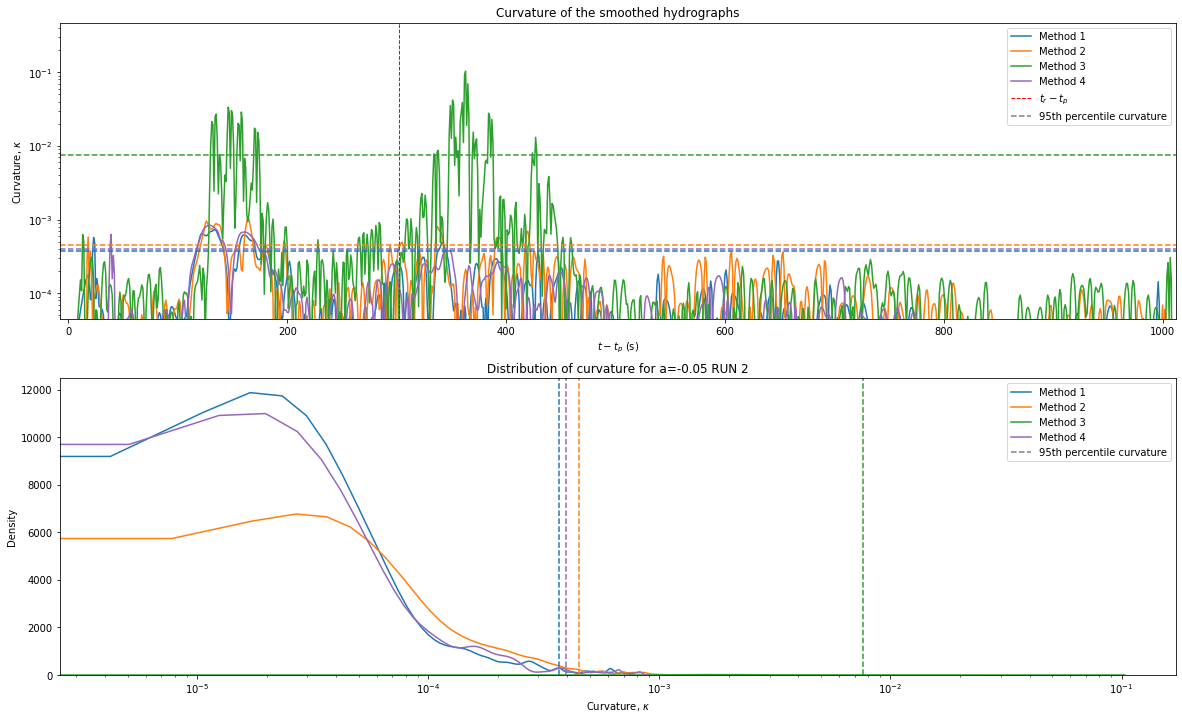

In [20]:
fig4 = plt.figure(1,(20,12))

ax6 = fig4.add_subplot(2,1,1)
ax6.plot(curvature_locreg_0,color='C0',label='Method 1')
ax6.plot(curvature_locreg_1,color='C1',label='Method 2')
ax6.plot(curvature_lowess,color='C2',label='Method 3')
ax6.plot(curvature_locreg_2,color='C4',label='Method 4')
ax6.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax6.axhline(high_curvature_locreg_0,linestyle='--',color='C0')
ax6.axhline(high_curvature_locreg_1,linestyle='--',color='C1')
ax6.axhline(high_curvature_lowess,linestyle='--',color='C2')
ax6.axhline(high_curvature_locreg_2,linestyle='--',color='C4')
ax6.plot(0,-1,linestyle='--',color='gray',label='95th percentile curvature')
ax6.set_yscale('log')
ax6.set_ylim(10**-1*np.mean(np.concatenate((curvature_locreg_0,curvature_locreg_1,curvature_lowess,curvature_locreg_2))),)
ax6.set_xlim(t_tp[0],t_tp[-1])
ax6.legend()
ax6.set_xlabel('$t - t_p$ (s)')
ax6.set_ylabel('Curvature, $\\kappa$')
ax6.set_title('Curvature of the smoothed hydrographs')

ax7 = fig4.add_subplot(2,1,2)
sns.distplot(curvature_locreg_0,color='C0',hist=False,norm_hist=True,ax=ax7,label='Method 1')
sns.distplot(curvature_locreg_1,color='C1',hist=False,norm_hist=True,ax=ax7,label='Method 2')
sns.distplot(curvature_lowess,color='C2',hist=False,norm_hist=True,ax=ax7,label='Method 3')
sns.distplot(curvature_locreg_2,color='C4',hist=False,norm_hist=True,ax=ax7,label='Method 4')
ax7.axvline(high_curvature_locreg_0,linestyle='--',color='C0')
ax7.axvline(high_curvature_locreg_1,linestyle='--',color='C1')
ax7.axvline(high_curvature_lowess,linestyle='--',color='C2')
ax7.axvline(high_curvature_locreg_2,linestyle='--',color='C4')
ax7.plot(0,-1,linestyle='--',color='gray',label='95th percentile curvature')
ax7.set_xscale('log')
ax7.set_ylim(0,)
ax7.legend()
ax7.set_xlabel('Curvature, $\\kappa$')
ax7.set_ylabel('Density')
ax7.set_title('Distribution of curvature for '+slope+' '+run)

plt.show()

From the plot of curvature vs. time, we can see immediately that the Method 3 (green) hydrograph is much rougher (it has higher peaks in curvature).

In the density plot, the spread of curvature values for Method 3 is so large that the KDE curve appears flat. The remaining 3 methods are nearly comparable, with the Method 2 (orange) faring slightly worse (it has a slighlty higher 95th percentile curvature).

The 95th percentile curvature seems to track pretty well with how "rough" the hydrographs look, but the danger in always choosing the smoothing method with the lowest 95th percentile curvature is that it may over-smooth sharp "corners" that are actually in the signal, not the noise. Because of this, it's probably safer to use the mean frequency of concavity reversal.

We shall then define our **Roughness Index** as the mean frequency of concavity reversal, taken as twice the average frequency in the power spectrum of the hydrograph's second derivative curve.

We can now compare the methods by their Roughness Index and their RMSE to help us decide on the best method.

To find a smoothing method with a low Roughness Index and low RMSE *relative* to the other methods, we need to first convert the values to standard units (shift the values by the mean and scale them by the standard deviation).

In [21]:
mean_of_mean_dQ2dt2_freqs = np.mean([mean_dQ2dt2_freqs_locreg_0,mean_dQ2dt2_freqs_locreg_1,mean_dQ2dt2_freqs_lowess,mean_dQ2dt2_freqs_locreg_2])
std_of_mean_dQ2dt2_freqs = np.std([mean_dQ2dt2_freqs_locreg_0,mean_dQ2dt2_freqs_locreg_1,mean_dQ2dt2_freqs_lowess,mean_dQ2dt2_freqs_locreg_2])

mean_RMSE = np.mean([RMSE_locreg_0,RMSE_locreg_1,RMSE_lowess,RMSE_locreg_2])
std_RMSE = np.std([RMSE_locreg_0,RMSE_locreg_1,RMSE_lowess,RMSE_locreg_2])
            
mean_dQ2dt2_freqs_locreg_0_SU = (mean_dQ2dt2_freqs_locreg_0 - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs
mean_dQ2dt2_freqs_locreg_1_SU = (mean_dQ2dt2_freqs_locreg_1 - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs
mean_dQ2dt2_freqs_lowess_SU = (mean_dQ2dt2_freqs_lowess - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs
mean_dQ2dt2_freqs_locreg_2_SU = (mean_dQ2dt2_freqs_locreg_2 - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs

RMSE_locreg_0_SU = (RMSE_locreg_0 - mean_RMSE)/std_RMSE
RMSE_locreg_1_SU = (RMSE_locreg_1 - mean_RMSE)/std_RMSE
RMSE_lowess_SU = (RMSE_lowess - mean_RMSE)/std_RMSE
RMSE_locreg_2_SU = (RMSE_locreg_2 - mean_RMSE)/std_RMSE

Plot the Roughness Index and the RMSE for each method in standard units.

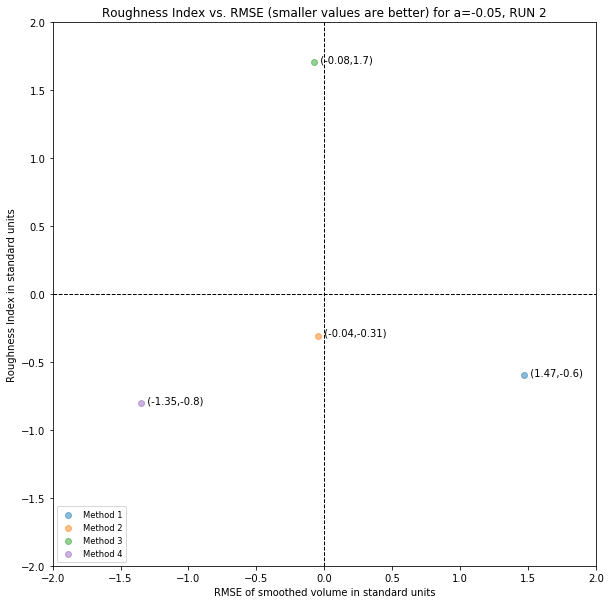

In [22]:
fig5 = plt.figure(1,(10,10))

ax8 = fig5.add_subplot(1,1,1)
ax8.axvline(0,linestyle='--',lw=1,color='k')
ax8.axhline(0,linestyle='--',lw=1,color='k')
ax8.scatter(RMSE_locreg_0_SU, mean_dQ2dt2_freqs_locreg_0_SU,alpha=0.5,color='C0',label='Method 1')
ax8.scatter(RMSE_locreg_1_SU, mean_dQ2dt2_freqs_locreg_1_SU,alpha=0.5,color='C1',label='Method 2')
ax8.scatter(RMSE_lowess_SU, mean_dQ2dt2_freqs_lowess_SU,alpha=0.5,color='C2',label='Method 3')
ax8.scatter(RMSE_locreg_2_SU, mean_dQ2dt2_freqs_locreg_2_SU,alpha=0.5,color='C4',label='Method 4')
ax8.annotate('  ('+str(np.round(RMSE_locreg_0_SU,2))+','+str(np.round(mean_dQ2dt2_freqs_locreg_0_SU,2))+')',
                         (RMSE_locreg_0_SU,mean_dQ2dt2_freqs_locreg_0_SU))
ax8.annotate('  ('+str(np.round(RMSE_locreg_1_SU,2))+','+str(np.round(mean_dQ2dt2_freqs_locreg_1_SU,2))+')',
                         (RMSE_locreg_1_SU,mean_dQ2dt2_freqs_locreg_1_SU))
ax8.annotate('  ('+str(np.round(RMSE_lowess_SU,2))+','+str(np.round(mean_dQ2dt2_freqs_lowess_SU,2))+')',
                         (RMSE_lowess_SU,mean_dQ2dt2_freqs_lowess_SU))
ax8.annotate('  ('+str(np.round(RMSE_locreg_2_SU,2))+','+str(np.round(mean_dQ2dt2_freqs_locreg_2_SU,2))+')',
                         (RMSE_locreg_2_SU,mean_dQ2dt2_freqs_locreg_2_SU))
ax8.set_aspect('equal',anchor='C')
ax8.set_xlim(-2,2)
ax8.set_ylim(-2,2)
ax8.legend(fontsize='small',loc=3)
ax8.set_xlabel('RMSE of smoothed volume in standard units')
ax8.set_ylabel('Roughness Index in standard units')
ax8.set_title('Roughness Index vs. RMSE (smaller values are better) for '+slope+', '+run)

plt.show()

We can see from this plot that, of the 4 methods, Method 4 (purple) resulted in the lowest volume RMSE and lowest Roughness Index (since it plotted in the bottom left corner of the graph. This visualization is somewhat trivial for one dataset, but will become helpful for determining the best smoothing method for **all** datasets.

## Test smoothing methods on all datasets

### Functionalize:

Write a function that takes the data from all runs, processes them as above, and plots the results. This function will be useful for quickly viewing the results from all the datasets as well as viewing individual datasets.  

The following just collects the code from the previous section into one function. (It's long but fairly convenient).

In [23]:
def smooth_and_plot(data,frac_lr_0 = 0.05,frac_lr_1 = 0.04,frac_lowess = 0.03,frac_lr_2 = 0.08,
                    slope=None,run=None,just_plot_summary=False,save=False,save_data=None):
    '''Smoothes data and plots volume curves, hydrographs, 
    and residuals for each run of a specified set of slopes and runs.
    
    Parameters
    ----------
    data: Pandas DataFrame
        Multilevel-indexed DataFrame with slopes, runs, times, masses, 
        notes, start and end times
    frac_lr_0: float, optional
        fraction of the data used for local 0th degree polynomial regression 
        (moving average) at each point
    frac_lr_1: float, optional
        fraction of the data used for local 1st degree polynomial regression 
        (LOWESS) at each point
    frac_lowess: float, optional
        fraction of the data used for local 1st degree polynomial regression 
        with 3 residual-based reweightings (LOWESS with reweighting) at each 
        point
    frac_lr_2: float, optional
        fraction of the data used for local 2nd degree polynomial (quadratic) 
        regression at each point
    slope: string or list, optional
        slope names. E.g. 'a=0.05' or ['a=0.05','a=-0.05']
    run: string or list, optional
        run names. E.g. 'RUN 1' or ['RUN 1','RUN 2']
    just_plot_summary: boolean, optional
        just_plot_summary=True just plots the 95th percentile curvature vs. 
        RMSE for all runs
    save: boolean, optional
        save=True saves the figure as a png
    save_data: str, optional
        save the differences of the smoothed data (from a preferred method)
        to a multi-level indexed Pandas Dataframe
        
        if save_data == 'locreg_0':
            save discharge data from moving average smoothing
        if save_data == 'locreg_1':
            save discharge from LOWESS (linear)
        if save_data == 'lowess_rw':
            save discharge data from LOWESS (linear) 
            with 3 residual-based reweightings
        if save_data == 'locreg_2':
            save discharge data from local quadratic regression
    
    Returns
    -------
    out : matplotlib.pyplot figure 
        A grid of subplots.
    '''
    
    #initialize arrays for for loop
    
    all_RMSE_locreg_0_SU = np.array([])
    all_RMSE_locreg_1_SU = np.array([])
    all_RMSE_lowess_SU = np.array([])
    all_RMSE_locreg_2_SU = np.array([])
    
    all_mean_dQ2dt2_freqs_locreg_0_SU = np.array([])
    all_mean_dQ2dt2_freqs_locreg_1_SU = np.array([])
    all_mean_dQ2dt2_freqs_lowess_SU = np.array([])
    all_mean_dQ2dt2_freqs_locreg_2_SU = np.array([])
    
    #get the number of rows and columns needed for the final grid of plots
    
    if slope == None:
        slopes_f = data.columns.levels[0].values    
    else:
        if type(slope) == str:
            slopes_f = [slope]
        else:
            slopes_f = slope
    
    tot_num_runs = len(data.columns.get_level_values(1))/len(np.unique(data.columns.get_level_values(2)))
    
    if run == None:
        num_cols = len(np.unique(data[slopes_f].columns.get_level_values(1).values))
    elif type(run) == str:
        num_cols = 1
    else:
        num_cols = len(run)
        
    num_rows = 8*len(slopes_f)+2
    
    #create a figure (unless overidden) and perform calculations and 
    #plot results for each individual run
    
    if save_data == None:
        if just_plot_summary == False:
            fig = plt.subplots(squeeze=False,figsize=(9*num_cols,5*num_rows))
    
    #initialize a dataframe for the smoothed data
    
    third_level = data.columns.get_level_values(2).values
    third_level[third_level == 'mass (g)'] = 'Q (cm3/s)'
    third_level[third_level == 'time (s)'] = 't - tp'
    third_level[third_level == 'notes'] = 'dQdt (cm3/s2)'
    third_level[third_level == 'start'] = 'd2Qdt2 (cm3/s3)'
    third_level[third_level == 'stop'] = 'tr - tp'
    
    smooth_df = pd.DataFrame(columns=[data.columns.get_level_values(0).values,
                                    data.columns.get_level_values(1).values,
                                    third_level])
    
    for i in np.arange(len(slopes_f)):
        slope_f = slopes_f[i]
        
        if run == None:
            runs_f = np.unique(data[slope_f].columns.get_level_values(0).values)
        else:
            if type(run) == str:
                runs_f = [run]
            else:
                runs_f = run
        
        for j in np.arange(len(runs_f)):
            run_f = runs_f[j]
    
            #get the data for each run in each slope
        
            untrimmed_data = data[slope_f][run_f]
            t_p = untrimmed_data['start'].values[0]
            t_r = untrimmed_data['stop'].values[0]
    
            if np.sum(np.isnan(untrimmed_data['mass (g)'])==True) != 0:
                last_index = -1 + np.where(np.isnan(untrimmed_data['mass (g)'])==True)[0][0]
                if np.sum(untrimmed_data['notes']=='<-tare') == 1:
                    tare_index = np.where(untrimmed_data['notes']=='<-tare')[0][0]
                    data_f = untrimmed_data.loc[tare_index:last_index]
                else:
                    tare_index = 0
                    data_f = untrimmed_data.loc[tare_index:last_index]

            else:
                if np.sum(untrimmed_data['notes']=='<-tare') == 1:
                    tare_index = np.where(untrimmed_data['notes']=='<-tare')[0][0]
                    data_f = untrimmed_data.loc[tare_index:]
                else:
                    tare_index = 0
                    data_f = untrimmed_data.loc[tare_index:]
    
            #convert units, smoothe, and take central differences
        
            density = 1 #g/cm^3
            time = data_f['time (s)'].values
            t_tp = time - t_p
    
            mass = data_f['mass (g)'].values
            volume_cm3 = mass/density
            volume_diff = np.gradient(volume_cm3,t_tp)

            lowess_volume_and_time = sm.nonparametric.lowess(volume_cm3,t_tp,frac=frac_lowess)
            lowess_volume_cm3 = lowess_volume_and_time[:,1]

            locreg_deg_0_volume_cm3= localreg.localreg(t_tp, volume_cm3, degree=0, kernel=localreg.tricube, frac=frac_lr_0)
            locreg_deg_1_volume_cm3= localreg.localreg(t_tp, volume_cm3, degree=1, kernel=localreg.tricube, frac=frac_lr_1)
            locreg_deg_2_volume_cm3= localreg.localreg(t_tp, volume_cm3, degree=2, kernel=localreg.tricube, frac=frac_lr_2)

            diff_lowess_volume_cm3 = np.gradient(lowess_volume_cm3,t_tp)
            diff_locreg_deg_0_volume_cm3 = np.gradient(locreg_deg_0_volume_cm3,t_tp)
            diff_locreg_deg_1_volume_cm3 = np.gradient(locreg_deg_1_volume_cm3,t_tp)
            diff_locreg_deg_2_volume_cm3 = np.gradient(locreg_deg_2_volume_cm3,t_tp)

            residuals_lowess_vol = volume_cm3 - lowess_volume_cm3
            residuals_locreg_0_vol = volume_cm3 - locreg_deg_0_volume_cm3
            residuals_locreg_1_vol = volume_cm3 - locreg_deg_1_volume_cm3
            residuals_locreg_2_vol = volume_cm3 - locreg_deg_2_volume_cm3

            #evaluate smoothing methods
            
            RMSE_lowess = np.sqrt(np.mean(residuals_lowess_vol**2))
            RMSE_locreg_0 = np.sqrt(np.mean(residuals_locreg_0_vol**2))
            RMSE_locreg_1 = np.sqrt(np.mean(residuals_locreg_1_vol**2))
            RMSE_locreg_2 = np.sqrt(np.mean(residuals_locreg_2_vol**2))
            
            dQdt_lowess = np.gradient(diff_lowess_volume_cm3,t_tp)
            dQdt_locreg_0 = np.gradient(diff_locreg_deg_0_volume_cm3,t_tp)
            dQdt_locreg_1 = np.gradient(diff_locreg_deg_1_volume_cm3,t_tp)
            dQdt_locreg_2 = np.gradient(diff_locreg_deg_2_volume_cm3,t_tp)

            dQ2dt2_lowess = np.gradient(dQdt_lowess,t_tp)
            dQ2dt2_locreg_0 = np.gradient(dQdt_locreg_0,t_tp)
            dQ2dt2_locreg_1 = np.gradient(dQdt_locreg_1,t_tp)
            dQ2dt2_locreg_2 = np.gradient(dQdt_locreg_2,t_tp)
            
            dQ2dt2_freqs_lowess,dQ2dt2_power_lowess = signal.periodogram(dQ2dt2_lowess,window='hanning')
            dQ2dt2_freqs_locreg_0,dQ2dt2_power_locreg_0 = signal.periodogram(dQ2dt2_locreg_0,window='hanning')
            dQ2dt2_freqs_locreg_1,dQ2dt2_power_locreg_1 = signal.periodogram(dQ2dt2_locreg_1,window='hanning')
            dQ2dt2_freqs_locreg_2,dQ2dt2_power_locreg_2 = signal.periodogram(dQ2dt2_locreg_2,window='hanning')

            mean_dQ2dt2_freqs_lowess = np.sum(dQ2dt2_freqs_lowess*dQ2dt2_power_lowess)/np.sum(dQ2dt2_power_lowess)
            mean_dQ2dt2_freqs_locreg_0 = np.sum(dQ2dt2_freqs_locreg_0*dQ2dt2_power_locreg_0)/np.sum(dQ2dt2_power_locreg_0)
            mean_dQ2dt2_freqs_locreg_1 = np.sum(dQ2dt2_freqs_locreg_1*dQ2dt2_power_locreg_1)/np.sum(dQ2dt2_power_locreg_1)
            mean_dQ2dt2_freqs_locreg_2 = np.sum(dQ2dt2_freqs_locreg_2*dQ2dt2_power_locreg_2)/np.sum(dQ2dt2_power_locreg_2)

            #convert to standard units
            
            mean_of_mean_dQ2dt2_freqs = np.mean([mean_dQ2dt2_freqs_locreg_0,mean_dQ2dt2_freqs_locreg_1,mean_dQ2dt2_freqs_lowess,mean_dQ2dt2_freqs_locreg_2])
            std_of_mean_dQ2dt2_freqs = np.std([mean_dQ2dt2_freqs_locreg_0,mean_dQ2dt2_freqs_locreg_1,mean_dQ2dt2_freqs_lowess,mean_dQ2dt2_freqs_locreg_2])

            mean_RMSE = np.mean([RMSE_locreg_0,RMSE_locreg_1,RMSE_lowess,RMSE_locreg_2])
            std_RMSE = np.std([RMSE_locreg_0,RMSE_locreg_1,RMSE_lowess,RMSE_locreg_2])
            
            mean_dQ2dt2_freqs_locreg_0_SU = (mean_dQ2dt2_freqs_locreg_0 - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs
            mean_dQ2dt2_freqs_locreg_1_SU = (mean_dQ2dt2_freqs_locreg_1 - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs
            mean_dQ2dt2_freqs_lowess_SU = (mean_dQ2dt2_freqs_lowess - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs
            mean_dQ2dt2_freqs_locreg_2_SU = (mean_dQ2dt2_freqs_locreg_2 - mean_of_mean_dQ2dt2_freqs)/std_of_mean_dQ2dt2_freqs

            RMSE_locreg_0_SU = (RMSE_locreg_0 - mean_RMSE)/std_RMSE
            RMSE_locreg_1_SU = (RMSE_locreg_1 - mean_RMSE)/std_RMSE
            RMSE_lowess_SU = (RMSE_lowess - mean_RMSE)/std_RMSE
            RMSE_locreg_2_SU = (RMSE_locreg_2 - mean_RMSE)/std_RMSE

            all_mean_dQ2dt2_freqs_locreg_0_SU = np.append(all_mean_dQ2dt2_freqs_locreg_0_SU,mean_dQ2dt2_freqs_locreg_0_SU)
            all_mean_dQ2dt2_freqs_locreg_1_SU = np.append(all_mean_dQ2dt2_freqs_locreg_1_SU,mean_dQ2dt2_freqs_locreg_1_SU)
            all_mean_dQ2dt2_freqs_lowess_SU = np.append(all_mean_dQ2dt2_freqs_lowess_SU,mean_dQ2dt2_freqs_lowess_SU)
            all_mean_dQ2dt2_freqs_locreg_2_SU = np.append(all_mean_dQ2dt2_freqs_locreg_2_SU,mean_dQ2dt2_freqs_locreg_2_SU)

            all_RMSE_locreg_0_SU = np.append(all_RMSE_locreg_0_SU,RMSE_locreg_0_SU)
            all_RMSE_locreg_1_SU = np.append(all_RMSE_locreg_1_SU,RMSE_locreg_1_SU)
            all_RMSE_lowess_SU = np.append(all_RMSE_lowess_SU,RMSE_lowess_SU)
            all_RMSE_locreg_2_SU = np.append(all_RMSE_locreg_2_SU,RMSE_locreg_2_SU)
            
            #plot all results unless overidden. if overidden, save data to smooth_df
            
            if save_data != None:
                if save_data == 'locreg_0':
                    smooth_diff = diff_locreg_deg_0_volume_cm3
                    dQdt = dQdt_locreg_0
                    dQ2dt2 = dQ2dt2_locreg_0
                    curvature = curvature_locreg_0
                if save_data == 'locreg_1':
                    smooth_diff = diff_locreg_deg_1_volume_cm3
                    dQdt = dQdt_locreg_1
                    dQ2dt2 = dQ2dt2_locreg_1
                    curvature = curvature_locreg_1
                if save_data == 'lowess_rw':
                    smooth_diff = diff_lowess_volume_cm3
                    dQdt = dQdt_lowess
                    dQ2dt2 = dQ2dt2_lowess
                    curvature = curvature_lowess
                if save_data == 'locreg_2':
                    smooth_diff = diff_locreg_deg_2_volume_cm3
                    dQdt = dQdt_locreg_2
                    dQ2dt2 = dQ2dt2_locreg_2
                    curvature = curvature_locreg_2
                
                nan_arr = np.nan*np.ones(data.shape[0]-len(t_tp))
                nan_arr2 = np.nan*np.ones(data.shape[0]-1)
                smooth_df[slope_f,run_f,'t - tp'] = np.append(t_tp,nan_arr)
                smooth_df[slope_f,run_f,'Q (cm3/s)'] = np.append(smooth_diff,nan_arr)
                smooth_df[slope_f,run_f,'dQdt (cm3/s2)'] = np.append(dQdt,nan_arr)
                smooth_df[slope_f,run_f,'d2Qdt2 (cm3/s3)'] = np.append(dQ2dt2,nan_arr)
                smooth_df[slope_f,run_f,'tr - tp'] = np.append(tr_tp,nan_arr2)
                
            if save_data == None:
                
                if just_plot_summary == False:

                    ax1text = plt.subplot2grid((num_rows, num_cols), (8*i, 0))
                    ax1text.text(0,0,slope_f,fontsize=30)
                    ax1text.axis('off')
                    ax1 = plt.subplot2grid((num_rows, num_cols), (8*i+1, j))
                    ax1.scatter(t_tp,volume_cm3,s=2,color='gray',label='raw volume data')
                    ax1.plot(t_tp,locreg_deg_0_volume_cm3,color='C0',label='Method 1')
                    ax1.plot(t_tp,locreg_deg_1_volume_cm3,color='C1',label='Method 2')
                    ax1.plot(t_tp,lowess_volume_cm3,color='C2',label='Method 3')
                    ax1.plot(t_tp,locreg_deg_2_volume_cm3,color='C4',label='Method 4')
                    ax1.set_xlim(t_tp[0],t_tp[-1])
                    ax1.legend()
                    ax1.set_xlabel('$t - t_p$ (s)')
                    ax1.set_ylabel('Volume (cm$^3$)')
                    ax1.set_title('Volume vs. time for '+slope_f+' '+run_f)

                    ax2 = plt.subplot2grid((num_rows, num_cols), (8*i+2, j))
                    ax2.scatter(t_tp,volume_diff,s=2,color='gray',label='difference quotients of raw data') 
                    ax2.plot(t_tp,diff_locreg_deg_0_volume_cm3,color='C0',label='Method 1')
                    ax2.plot(t_tp,diff_locreg_deg_1_volume_cm3,color='C1',label='Method 2')
                    ax2.plot(t_tp,diff_lowess_volume_cm3,color='C2',label='Method 3')
                    ax2.plot(t_tp,diff_locreg_deg_2_volume_cm3,color='C4',label='Method 4')
                    ax2.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
                    ax2.legend()
                    ax2.set_xlabel('$t - t_p$ (s)')
                    ax2.set_ylabel('Q (cm$^3$/s)')
                    ax2.set_ylim(-3*np.std(volume_diff)+np.mean(volume_diff),np.max(diff_lowess_volume_cm3)+np.std(volume_diff))#3*np.std(volume_diff)+np.mean(volume_diff))
                    ax2.set_xlim(t_tp[0],t_tp[-1])
                    ax2.set_title('Discharge hydrograph for '+slope_f+' '+run_f)

                    ax3 = plt.subplot2grid((num_rows, num_cols), (8*i+3, j))
                    ax3.scatter(time[int(t_r)-50:int(t_r)+50] - t_p,volume_diff[int(t_r)-50:int(t_r)+50],s=2,color='gray',label='difference quotients of raw data')
                    ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_locreg_deg_0_volume_cm3[int(t_r)-50:int(t_r)+50],color='C0',label='Method 1')
                    ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_locreg_deg_1_volume_cm3[int(t_r)-50:int(t_r)+50],color='C1',label='Method 2')
                    ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_lowess_volume_cm3[int(t_r)-50:int(t_r)+50],color='C2',label='Method 3')
                    ax3.plot(time[int(t_r)-50:int(t_r)+50] - t_p,diff_locreg_deg_2_volume_cm3[int(t_r)-50:int(t_r)+50],color='C4',label='Method 4')
                    ax3.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
                    ax3.legend()
                    ax3.set_xlabel('$t - t_p$ (s)')
                    ax3.set_ylabel('Q (cm$^3$/s)')
                    ax3.set_ylim(-3*np.std(volume_diff[int(t_r)-50:int(t_r)+50])+np.mean(volume_diff[int(t_r)-50:int(t_r)+50]),np.max(diff_lowess_volume_cm3[int(t_r)-50:int(t_r)+50])+np.std(volume_diff[int(t_r)-50:int(t_r)+50]))
                    ax3.set_xlim(time[int(t_r)-50]-t_p,time[int(t_r)+49]-t_p)
                    ax3.set_title('Close-up of discharge hydrograph for '+slope_f+' '+run_f)

                    ax4 = plt.subplot2grid((num_rows, num_cols), (8*i+4, j))
                    ax4.scatter(t_tp,residuals_locreg_0_vol,s=2,color='C0',label='Method 1')
                    ax4.scatter(t_tp,residuals_locreg_1_vol,s=2,color='C1',label='Method 2')
                    ax4.scatter(t_tp,residuals_lowess_vol,s=2,color='C2',label='Method 3')
                    ax4.scatter(t_tp,residuals_locreg_2_vol,s=2,color='C4',label='Method 4')
                    ax4.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
                    ax4.axhline(0,linestyle='--',lw=1,color='k')
                    ax4.legend()
                    ax4.set_xlabel('$t - t_p$ (s)')
                    ax4.set_ylabel('Volume (cm$^3$)')
                    ax4.set_xlim(t_tp[0],t_tp[-1])
                    ax4.set_ylim(np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) - 
                            3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])),
                            np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 
                            3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])))
                    ax4.set_title('Volume residuals vs. time for '+slope_f+' '+run_f)

                    ax5 = plt.subplot2grid((num_rows, num_cols), (8*i+5, j))
                    ax5.axvline(0,linestyle='--',lw=1,color='k')
                    sns.distplot(residuals_locreg_0_vol,color='C0',hist=False,norm_hist=True,ax=ax5,label='Method 1')
                    sns.distplot(residuals_locreg_1_vol,color='C1',hist=False,norm_hist=True,ax=ax5,label='Method 2')
                    sns.distplot(residuals_lowess_vol,color='C2',hist=False,norm_hist=True,ax=ax5,label='Method 3')
                    sns.distplot(residuals_locreg_2_vol,color='C4',hist=False,norm_hist=True,ax=ax5,label='Method 4')
                    ax5.axvline(np.mean(residuals_locreg_0_vol)-np.std(residuals_locreg_0_vol),linestyle='--',color='C0')
                    ax5.axvline(np.mean(residuals_locreg_1_vol)-np.std(residuals_locreg_1_vol),linestyle='--',color='C1')
                    ax5.axvline(np.mean(residuals_lowess_vol)-np.std(residuals_lowess_vol),linestyle='--',color='C2')
                    ax5.axvline(np.mean(residuals_locreg_2_vol)-np.std(residuals_locreg_2_vol),linestyle='--',color='C4')
                    ax5.axvline(np.mean(residuals_locreg_0_vol)+np.std(residuals_locreg_0_vol),linestyle='--',color='C0')
                    ax5.axvline(np.mean(residuals_locreg_1_vol)+np.std(residuals_locreg_1_vol),linestyle='--',color='C1')
                    ax5.axvline(np.mean(residuals_lowess_vol)+np.std(residuals_lowess_vol),linestyle='--',color='C2')
                    ax5.axvline(np.mean(residuals_locreg_2_vol)+np.std(residuals_locreg_2_vol),linestyle='--',color='C4')
                    ax5.plot(np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 
                              3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 1,0,
                              linestyle='--',color='gray',label='$\\mu \\pm 1\\sigma$')
                    ax5.legend()
                    ax5.set_xlabel('Volume residuals (cm$^3$)')
                    ax5.set_ylabel('Density')
                    ax5.set_xlim(np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) - 
                            3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])),
                            np.mean(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])) + 
                            3*np.std(np.concatenate([residuals_locreg_0_vol,residuals_locreg_1_vol,residuals_lowess_vol,residuals_locreg_2_vol])))
                    ax5.set_title('Distribution of volume residuals for '+slope_f+' '+run_f)

                    ax6 = plt.subplot2grid((num_rows, num_cols), (8*i+6, j))
                    ax6.plot(t_tp,dQ2dt2_locreg_0,color='C0',label='Method 1')
                    ax6.plot(t_tp,dQ2dt2_locreg_1,color='C1',label='Method 2')
                    ax6.plot(t_tp,dQ2dt2_lowess,color='C2',label='Method 3')
                    ax6.plot(t_tp,dQ2dt2_locreg_2,color='C4',label='Method 4')
                    ax6.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
                    ax6.set_ylim(-np.std(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2)))
                                          +np.mean(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2))),
                                  np.std(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2)))
                                          +np.mean(np.concatenate((dQ2dt2_locreg_0,dQ2dt2_locreg_1,dQ2dt2_lowess,dQ2dt2_locreg_2))))
                    ax6.set_xlim(t_tp[0],t_tp[-1])
                    ax6.legend()
                    ax6.set_xlabel('$t - t_p$ (s)')
                    ax6.set_ylabel('$\\frac{d^2Q}{dt^2}$ (cm$^3$/s$^3$)')
                    ax6.set_title('Second derivative of the smoothed hydrographs (close-up) for '+slope_f+' '+run_f)
                    
                    ax7 = plt.subplot2grid((num_rows, num_cols), (8*i+7, j))
                    ax7.plot(dQ2dt2_freqs_locreg_0,dQ2dt2_power_locreg_0,color='C0',label='Method 1')
                    ax7.plot(dQ2dt2_freqs_locreg_1,dQ2dt2_power_locreg_1,color='C1',label='Method 2')
                    ax7.plot(dQ2dt2_freqs_lowess,dQ2dt2_power_lowess,color='C2',label='Method 3')
                    ax7.plot(dQ2dt2_freqs_locreg_2,dQ2dt2_power_locreg_2,color='C4',label='Method 4')
                    ax7.axvline(mean_dQ2dt2_freqs_locreg_0,linestyle='--',color='C0')
                    ax7.axvline(mean_dQ2dt2_freqs_locreg_1,linestyle='--',color='C1')
                    ax7.axvline(mean_dQ2dt2_freqs_lowess,linestyle='--',color='C2')
                    ax7.axvline(mean_dQ2dt2_freqs_locreg_2,linestyle='--',color='C4')
                    ax7.plot(0,-1,linestyle='--',color='gray',label='average frequency')
                    ax7.legend()
                    ax7.set_ylim(0,np.mean(np.concatenate((dQ2dt2_power_locreg_0,dQ2dt2_power_locreg_1,
                                                            dQ2dt2_power_locreg_2)))+
                                  8*np.std(np.concatenate((dQ2dt2_power_locreg_0,dQ2dt2_power_locreg_1,
                                                         dQ2dt2_power_locreg_2))))
                    ax7.set_xlabel('Frequency')
                    ax7.set_ylabel('Power') 
                    ax7.set_title('Power spectra of second derivative curves (close-up) for '+slope_f+' '+run_f)
    
    avg_mean_dQ2dt2_freqs_locreg_0_SU = np.mean(all_mean_dQ2dt2_freqs_locreg_0_SU)
    avg_mean_dQ2dt2_freqs_locreg_1_SU = np.mean(all_mean_dQ2dt2_freqs_locreg_1_SU)
    avg_mean_dQ2dt2_freqs_lowess_SU = np.mean(all_mean_dQ2dt2_freqs_lowess_SU)
    avg_mean_dQ2dt2_freqs_locreg_2_SU = np.mean(all_mean_dQ2dt2_freqs_locreg_2_SU)
        
    avg_all_RMSE_locreg_0_SU = np.mean(all_RMSE_locreg_0_SU)   
    avg_all_RMSE_locreg_1_SU = np.mean(all_RMSE_locreg_1_SU)
    avg_all_RMSE_lowess_SU = np.mean(all_RMSE_lowess_SU)
    avg_all_RMSE_locreg_2_SU = np.mean(all_RMSE_locreg_2_SU)
    
    if save_data == None:
    
        if just_plot_summary == False:

            ax8text = plt.subplot2grid((num_rows, num_cols), (num_rows -2, 0))
            ax8text.text(0,0,'Comparison of smoothing methods:',fontsize=30)
            ax8text.axis('off')
            ax8 = plt.subplot2grid((num_rows, num_cols), (num_rows-1, 0))
            ax8.axvline(0,linestyle='--',lw=1,color='k')
            ax8.axhline(0,linestyle='--',lw=1,color='k')
            ax8.scatter(all_RMSE_locreg_0_SU, all_mean_dQ2dt2_freqs_locreg_0_SU,alpha=0.5,color='C0',label='Method 1')
            ax8.scatter(all_RMSE_locreg_1_SU, all_mean_dQ2dt2_freqs_locreg_1_SU,alpha=0.5,color='C1',label='Method 2')
            ax8.scatter(all_RMSE_lowess_SU, all_mean_dQ2dt2_freqs_lowess_SU,alpha=0.5,color='C2',label='Method 3')
            ax8.scatter(all_RMSE_locreg_2_SU, all_mean_dQ2dt2_freqs_locreg_2_SU,alpha=0.5,color='C4',label='Method 4')
            ax8.scatter(avg_all_RMSE_locreg_0_SU,avg_mean_dQ2dt2_freqs_locreg_0_SU,marker='v',color='C0')
            ax8.scatter(avg_all_RMSE_locreg_1_SU,avg_mean_dQ2dt2_freqs_locreg_1_SU,marker='v',color='C1')
            ax8.scatter(avg_all_RMSE_lowess_SU,avg_mean_dQ2dt2_freqs_lowess_SU,marker='v',color='C2')
            ax8.scatter(avg_all_RMSE_locreg_2_SU,avg_mean_dQ2dt2_freqs_locreg_2_SU,marker='v',color='C4')
            ax8.annotate('  ('+str(np.round(avg_all_RMSE_locreg_0_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_locreg_0_SU,2))+')',
                         (avg_all_RMSE_locreg_0_SU,avg_mean_dQ2dt2_freqs_locreg_0_SU))
            ax8.annotate('  ('+str(np.round(avg_all_RMSE_locreg_1_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_locreg_1_SU,2))+')',
                         (avg_all_RMSE_locreg_1_SU,avg_mean_dQ2dt2_freqs_locreg_1_SU))
            ax8.annotate('  ('+str(np.round(avg_all_RMSE_lowess_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_lowess_SU,2))+')',
                         (avg_all_RMSE_lowess_SU,avg_mean_dQ2dt2_freqs_lowess_SU))
            ax8.annotate('  ('+str(np.round(avg_all_RMSE_locreg_2_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_locreg_2_SU,2))+')',
                         (avg_all_RMSE_locreg_2_SU,avg_mean_dQ2dt2_freqs_locreg_2_SU))
            ax8.scatter(3,3,marker='v',color='k',label='average over all runs')
            ax8.set_aspect('equal',anchor='C')
            ax8.set_xlim(-2,2)
            ax8.set_ylim(-2,2)
            ax8.legend(fontsize='small')
            ax8.set_xlabel('RMSE of smoothed volume in standard units')
            ax8.set_ylabel('Roughness Index in standard units')
            ax8.set_title('Roughness Index vs. RMSE (smaller values are better)')

            plt.tight_layout()

        if just_plot_summary == True:

            fig2 = plt.figure(1,(10,10))
            ax9 = fig2.add_subplot(1,1,1)
            ax9.axvline(0,linestyle='--',lw=1,color='k')
            ax9.axhline(0,linestyle='--',lw=1,color='k')
            ax9.scatter(all_RMSE_locreg_0_SU, all_mean_dQ2dt2_freqs_locreg_0_SU,alpha=0.5,color='C0',label='Method 1')
            ax9.scatter(all_RMSE_locreg_1_SU, all_mean_dQ2dt2_freqs_locreg_1_SU,alpha=0.5,color='C1',label='Method 2')
            ax9.scatter(all_RMSE_lowess_SU, all_mean_dQ2dt2_freqs_lowess_SU,alpha=0.5,color='C2',label='Method 3')
            ax9.scatter(all_RMSE_locreg_2_SU, all_mean_dQ2dt2_freqs_locreg_2_SU,alpha=0.5,color='C4',label='Method 4')
            ax9.scatter(avg_all_RMSE_locreg_0_SU,avg_mean_dQ2dt2_freqs_locreg_0_SU,marker='v',color='C0')
            ax9.scatter(avg_all_RMSE_locreg_1_SU,avg_mean_dQ2dt2_freqs_locreg_1_SU,marker='v',color='C1')
            ax9.scatter(avg_all_RMSE_lowess_SU,avg_mean_dQ2dt2_freqs_lowess_SU,marker='v',color='C2')
            ax9.scatter(avg_all_RMSE_locreg_2_SU,avg_mean_dQ2dt2_freqs_locreg_2_SU,marker='v',color='C4')
            ax9.annotate('  ('+str(np.round(avg_all_RMSE_locreg_0_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_locreg_0_SU,2))+')',
                         (avg_all_RMSE_locreg_0_SU,avg_mean_dQ2dt2_freqs_locreg_0_SU))
            ax9.annotate('  ('+str(np.round(avg_all_RMSE_locreg_1_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_locreg_1_SU,2))+')',
                         (avg_all_RMSE_locreg_1_SU,avg_mean_dQ2dt2_freqs_locreg_1_SU))
            ax9.annotate('  ('+str(np.round(avg_all_RMSE_lowess_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_lowess_SU,2))+')',
                         (avg_all_RMSE_lowess_SU,avg_mean_dQ2dt2_freqs_lowess_SU))
            ax9.annotate('  ('+str(np.round(avg_all_RMSE_locreg_2_SU,2))+','+str(np.round(avg_mean_dQ2dt2_freqs_locreg_2_SU,2))+')',
                         (avg_all_RMSE_locreg_2_SU,avg_mean_dQ2dt2_freqs_locreg_2_SU))
            
            ax9.scatter(3,3,marker='v',color='k',label='average over all runs')
            ax9.set_aspect('equal',anchor='C')
            ax9.set_xlim(-2,2)
            ax9.set_ylim(-2,2)
            ax9.legend()
            ax9.set_xlabel('RMSE of smoothed volume in standard units')
            ax9.set_ylabel('Roughness Index in standard units')
            ax9.set_title('Roughness Index vs. RMSE (smaller values are better)')
            
        if save == True:
            plt.savefig('hydrographs.pdf')
    
        plt.show()
    
    else:
        return smooth_df

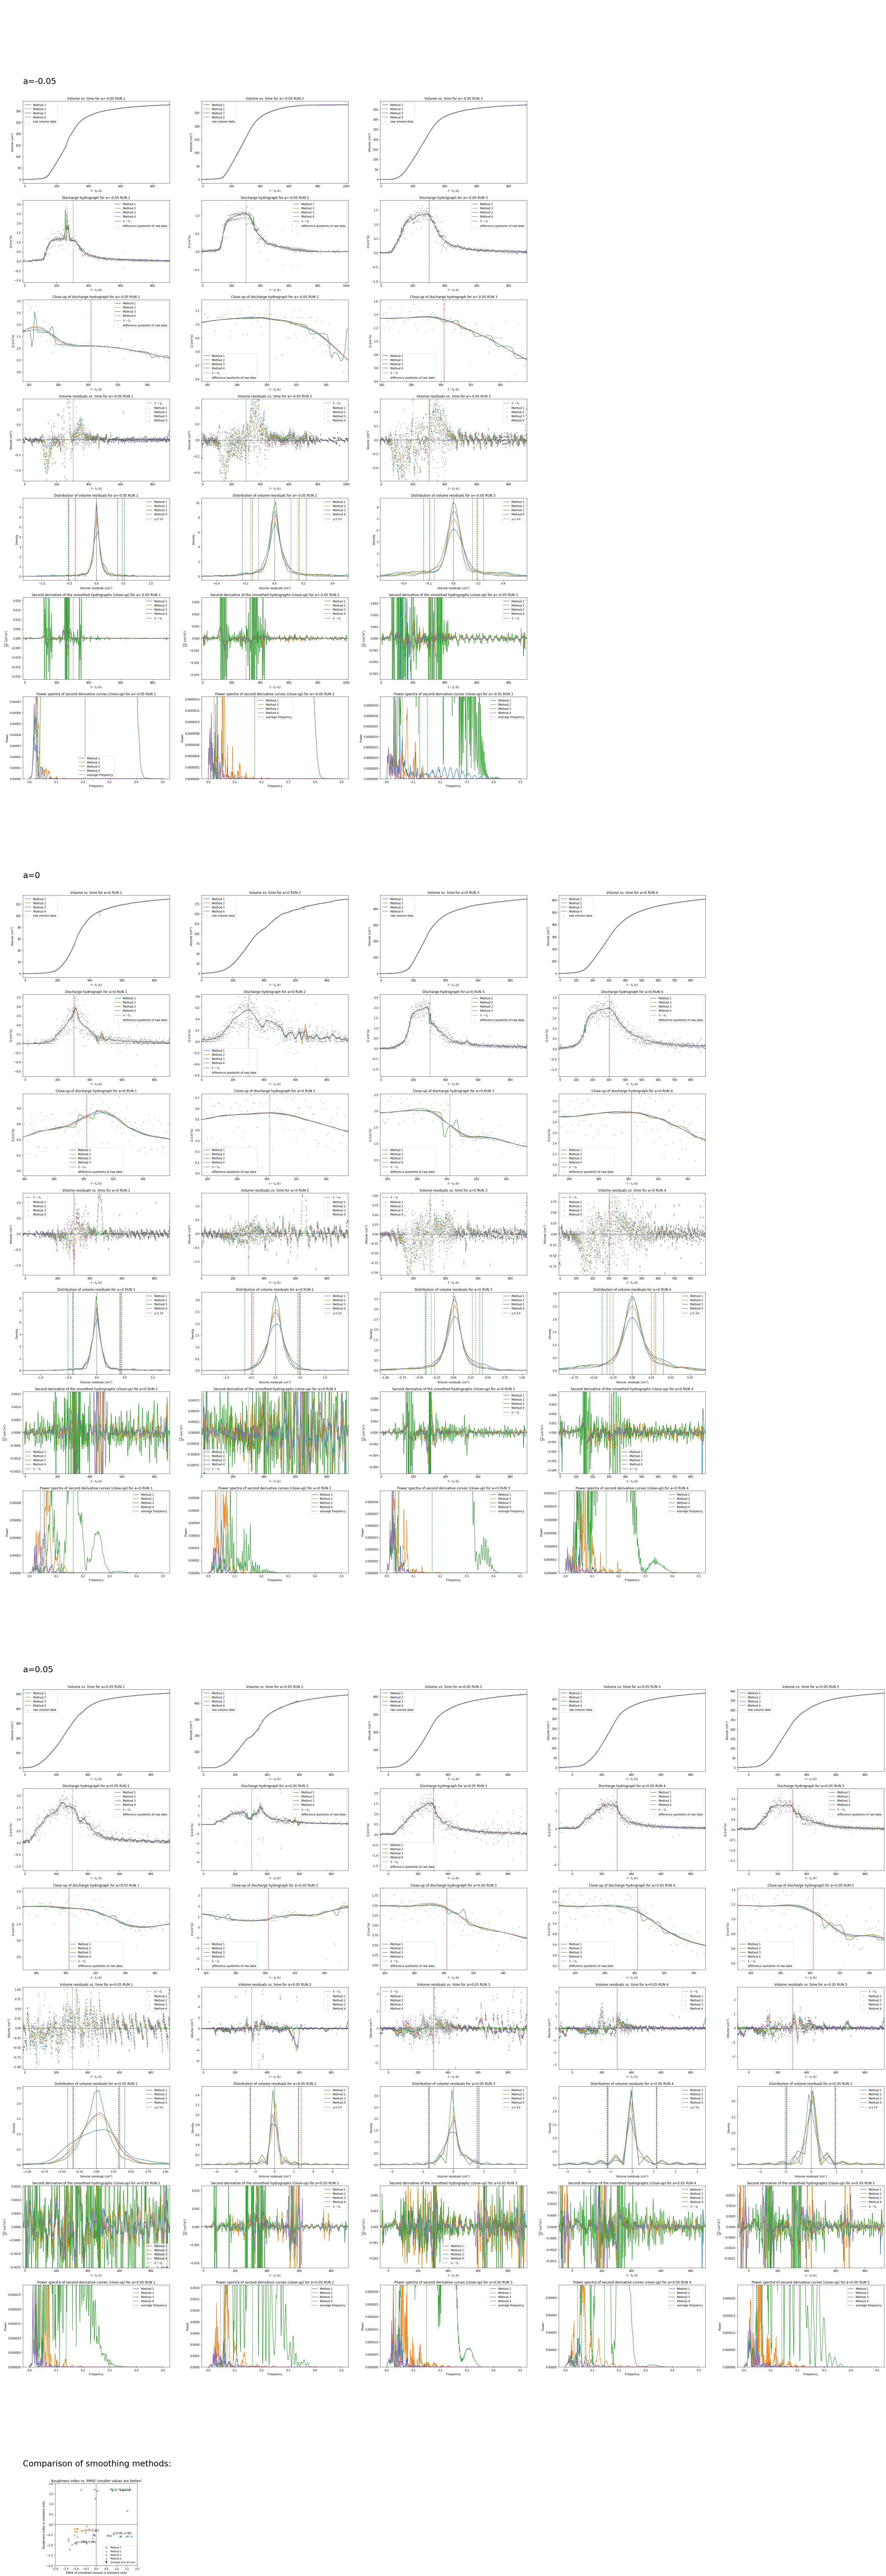

In [24]:
#this function may take a minute to run

smooth_and_plot(full_data)

There's a lot of data to take in visually, but we can see quickly that the $f$ values are tuned fairly well since all of the curves are pretty smooth and close to the data. We can also see by checking the residual and second derivative ($\frac{d^2Q}{dt^2}$) plots that the the RMSE and the Roughness Index do a pretty good job of describing the fit and the smoothness.  

To compare methods by their fit and smoothness, we can plot the Roughness Index vs. RMSE as a larger figure below:

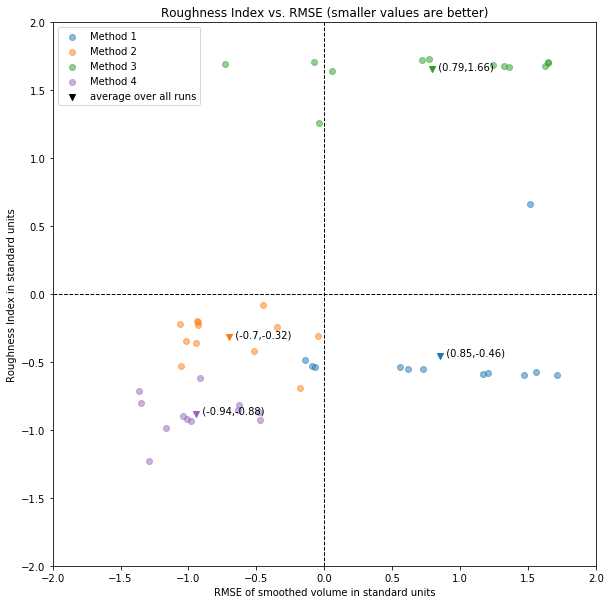

In [25]:
smooth_and_plot(full_data,just_plot_summary=True)

The cluster of purple points in the lower left corner shows that for any given run in the dataset, Method 4 has (on average) a lower Roughness Index *and* a lower RMSE than any other of the 4 methods. Method 4 is smoother and better fit to the data by our standards.

**So, we can say, that for this dataset, the best smoothing method we have tried is Method 4: locally-weighted quadratic regression (without residual-based reweightings) using a tricubic kernel that includes 8% of the data at each point ($f$ = 0.08, $d$ = 2, $t$ = 0, kernel: tricubic).**

## Smoothe all runs in the dataset

We can use the function `smooth_and_plot` to save the smooth hydrograph data (using Method 4 only) in a multi-index Pandas DataFrame.

In [26]:
smooth_data = smooth_and_plot(full_data,save_data='locreg_2')
smooth_data.head(5)

a=0.05                                                                   \
   RUN 1                                                  RUN 2             
  t - tp Q (cm3/s) dQdt (cm3/s2) d2Qdt2 (cm3/s3) tr - tp t - tp Q (cm3/s)   
0  -13.0  0.032103      0.000973        0.000483   302.0  -11.0 -0.000027   
1  -12.0  0.033076      0.001456        0.000478     NaN  -10.0  0.000041   
2  -11.0  0.035015      0.001930        0.000229     NaN   -9.0  0.000177   
3  -10.0  0.036937      0.001913       -0.000018     NaN   -8.0  0.000312   
4   -9.0  0.038841      0.001895       -0.000018     NaN   -7.0  0.000445   

                                                                        \
                                         RUN 3                           
  dQdt (cm3/s2) d2Qdt2 (cm3/s3) tr - tp t - tp Q (cm3/s) dQdt (cm3/s2)   
0      0.000068        0.000034   302.0  -53.0  0.027132      0.000174   
1      0.000102        0.000034     NaN  -52.0  0.027306      0.000258   
2      0.000135        0.000016     NaN  -51.0  0.027648      0.000338   
3      0.000134       -0.000001     NaN  -50.0  0.027981      0.000328   
4      0.000132       -0.000002     NaN  -49.0  0.028304      0.000318   

                                                                          \
                           RUN 4                                           
  d2Qdt2 (cm3/s3) tr - tp t - tp Q (cm3/s) dQdt (cm3/s2) d2Qdt2 (cm3/s3)   
0        0.000084   302.0  -90.0  0.059342      0.000082        0.000041   
1        0.000082     NaN  -89.0  0.059424      0.000123        0.000040   
2        0.000035     NaN  -88.0  0.059588      0.000162        0.000019   
3       -0.000010     NaN  -87.0  0.059749      0.000160       -0.000002   
4       -0.000010     NaN  -86.0  0.059908      0.000158       -0.000002   

                                                                 a=-0.05  \
           RUN 5                                                   RUN 1   
  tr - tp t - tp Q (cm3/s) dQdt (cm3/s2) d2Qdt2 (cm3/s3) tr - tp  t - tp   
0   302.0  -77.0  0.061627      0.000180        0.000080   302.0   -12.0   
1     NaN  -76.0  0.061807      0.000259        0.000069     NaN   -11.0   
2     NaN  -75.0  0.062146      0.000318        0.000007     NaN   -10.0   
3     NaN  -74.0  0.062442      0.000274       -0.000046     NaN    -9.0   
4     NaN  -73.0  0.062693      0.000226       -0.000048     NaN    -8.0   

                                                                    \
                                                   RUN 2             
  Q (cm3/s) dQdt (cm3/s2) d2Qdt2 (cm3/s3) tr - tp t - tp Q (cm3/s)   
0  0.005445     -0.000044       -0.000021   302.0   -8.0  0.010229   
1  0.005400     -0.000066       -0.000020     NaN   -7.0  0.010282   
2  0.005313     -0.000085       -0.000008     NaN   -6.0  0.010391   
3  0.005230     -0.000081        0.000004     NaN   -5.0  0.010503   
4  0.005150     -0.000077        0.000005     NaN   -4.0  0.010621   

                                                                        \
                                         RUN 3                           
  dQdt (cm3/s2) d2Qdt2 (cm3/s3) tr - tp t - tp Q (cm3/s) dQdt (cm3/s2)   
0      0.000053        0.000028   302.0   -5.0 -0.000216      0.000065   
1      0.000081        0.000029     NaN   -4.0 -0.000150      0.000099   
2      0.000110        0.000017     NaN   -3.0 -0.000017      0.000135   
3      0.000115        0.000005     NaN   -2.0  0.000120      0.000140   
4      0.000121        0.000006     NaN   -1.0  0.000263      0.000145   

                             a=0                                          \
                           RUN 1                                           
  d2Qdt2 (cm3/s3) tr - tp t - tp Q (cm3/s) dQdt (cm3/s2) d2Qdt2 (cm3/s3)   
0        0.000034   302.0  -14.0  0.002125     -0.000009   -4.065702e-06   
1        0.000035     NaN  -13.0  0.002116     -0.000013   -3.678830e-06   
2        0.000021     NaN  -12.0  0.0020

In [27]:
#smooth_data.to_excel('smooth_hydrographs1.xlsx')

# Plot Error Bands:

In producing smooth hydrographs we have removed a lot of noise, which may give an unrealistic picture of how precise the curves are. It would be useful to estimate the propagated error at each point in each hydrograph and visualize it using error bands.  

We can start by estimating the error for run 2 of slope a=-0.05:

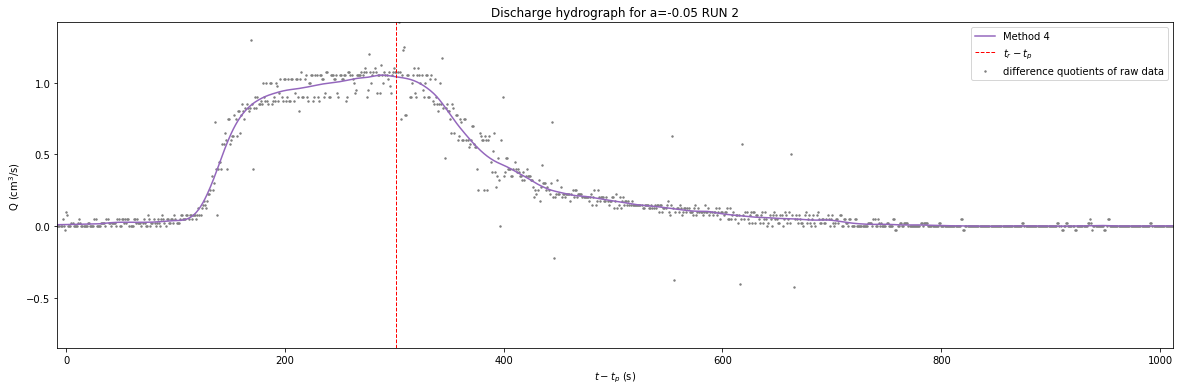

In [28]:
fig6 = plt.figure(1,(20,6))

ax9 = fig6.add_subplot(1,1,1)
ax9.scatter(t_tp,volume_diff,s=2,color='gray',label='difference quotients of raw data') 
ax9.plot(t_tp,diff_locreg_deg_2_volume_cm3,color='C4',label='Method 4')
ax9.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax9.legend()
ax9.set_xlabel('$t - t_p$ (s)')
ax9.set_ylabel('Q (cm$^3$/s)')
ax9.set_ylim(-3*np.std(volume_diff)+np.mean(volume_diff),np.max(diff_lowess_volume_cm3)+np.std(volume_diff))#3*np.std(volume_diff)+np.mean(volume_diff))
ax9.set_xlim(t_tp[0],t_tp[-1])
ax9.set_title('Discharge hydrograph for '+slope+' '+run)

plt.show()

The scale used for the raw mass measurements is precise to every 0.05 g. We can then say that the error for each raw mass measurement is $\pm$0.025 g. In a method similar to bootstrapping, we can simulate many mass time series from the existing data and from the measurement error. To do this, we randomly sample from normal distributions centered at each measurement value and scaled such that one standard deviation is equal to the measurement error (0.025 g).

In [29]:
#instead of using a for-loop, create a 2D numpy array of simulated mass values with one row for each simulation.

mass_err = 0.025 #g

num_sims = 1000

sim_mass = np.random.normal(loc=mass,scale=mass_err,size=(num_sims,len(mass)))
sim_volume_cm3 = sim_mass/density
sim_volume_diff = np.gradient(sim_volume_cm3,t_tp,axis=1)

Apply smoothing Method 4 to each simulated volume time series.

In [30]:
#this cell may take a few minutes to run

def locreg_2(sim_volume_1D_arr):
    sim_locreg_deg_2_volume = localreg.localreg(
        t_tp, sim_volume_1D_arr, degree=2, kernel=localreg.tricube, frac=frac_lr_2)
    return sim_locreg_deg_2_volume

sim_locreg_deg_2_volume_cm3 = np.apply_along_axis(func1d=locreg_2,axis=1,arr=sim_volume_cm3)

Take finite differences of each simulated time series and then calculate the standard deviation of the simulated values *at each time*.

In [31]:
sim_diff_locreg_deg_2_volume_cm3 = np.gradient(sim_locreg_deg_2_volume_cm3,t_tp,axis=1)
diff_locreg_deg_2_volume_cm3_err = np.std(sim_diff_locreg_deg_2_volume_cm3,axis=0)

Plot the standard errors as bands around smooth hydrograph.

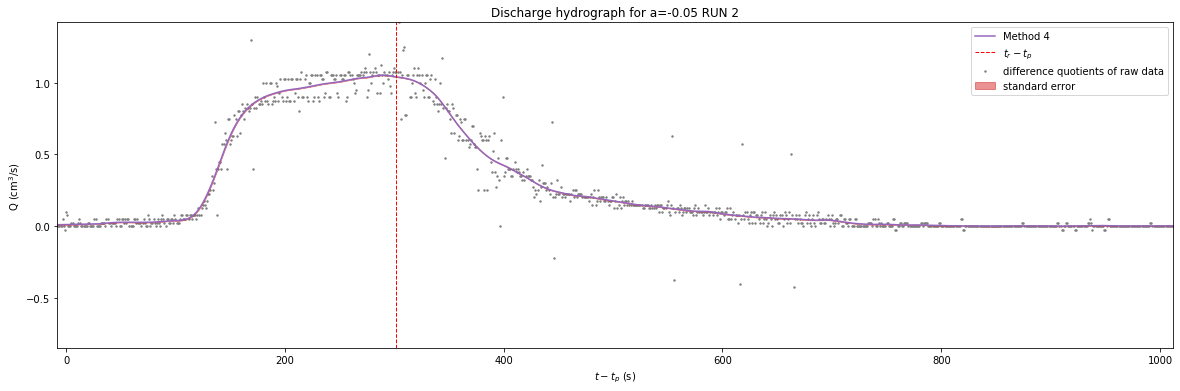

In [32]:
fig7 = plt.figure(1,(20,6))
ax10 = fig7.add_subplot(1,1,1)
ax10.scatter(t_tp,volume_diff,s=2,color='gray',label='difference quotients of raw data') 
ax10.plot(t_tp,diff_locreg_deg_2_volume_cm3,color='C4',label='Method 4')
ax10.fill_between(t_tp,diff_locreg_deg_2_volume_cm3+diff_locreg_deg_2_volume_cm3_err,
                  diff_locreg_deg_2_volume_cm3-diff_locreg_deg_2_volume_cm3_err,
                  alpha=0.5,color='C3',label='standard error')
ax10.axvline(tr_tp,linestyle='--',lw=1,color='red',label='$t_r - t_p$')
ax10.legend()
ax10.set_xlabel('$t - t_p$ (s)')
ax10.set_ylabel('Q (cm$^3$/s)')
ax10.set_ylim(-3*np.std(volume_diff)+np.mean(volume_diff),np.max(diff_lowess_volume_cm3)+np.std(volume_diff))#3*np.std(volume_diff)+np.mean(volume_diff))
ax10.set_xlim(t_tp[0],t_tp[-1])
ax10.set_title('Discharge hydrograph for '+slope+' '+run)

plt.show()

Since the error bands are nearly indistinguishable from the original curve, we can see that the propagated error in measurement is almost negligible. However, this should not lead to a false sense of confidence in the smooth hydrograph, since the error bands represent the propagated error in measurement assuming that the smoothing is accurate, not the confidence in the smoothing process. Confidence in the smoothing is not conducted as part of this work.

# Summary

This notebook was primarily concerned with developing methods to process laboratory data in a reproducible manner and facilitate the comparison of analytical and experimental results. As expected, this method of measurement and recording introduced a lot of noise into the data: the scale has a precision of 0.025g and "jumps" in its readings, imperfections in the slope can causing pooling and sudden outbursts of water, and some measurements on the scale display cannot be read. The cumulative mass vs. time curves are visually "smooth", but the hydrographs (which are essentially the derivatives of these curves) are very noisy, making comparison to analytical hydrographs difficult. The work in this notebook allows us to produce smooth hydrographs for comparison with anaylitical solutions in a reliable manner.

# Works cited

Cleveland, W. S. (1979). Robust locally weighted regression and smoothing scatterplots. Journal of the American Statistical Association, 74(368), 829–836. https://doi.org/10.1080/01621459.1979.10481038

Giráldez, J. V., & Woolhiser, D. A. (1996). Analytical Integration of the Kinematic Equation for Runoff on a Plane Under Constant Rainfall Rate and Smith and Parlange Infiltration. Water Resources Research, 32(11), 3385–3389. https://doi.org/10.1029/96WR02106

Lapides, D., Sytsma, S., David, C., Dralle, D., Nichols, M., & Thompson, S. (2020). Constraints on the validity of the Rational Method for identifying peak discharge on pervious hillslopes under idealized runoff generation conditions. In Progress.